# 1. 使用注意力机制的seq2seq

In [1]:
import torch
from torch import nn
from d2l import torch as d2l
import os

In [2]:
# 带有注意力机制的解码器基本接口
class AttentionDecoder(d2l.Decoder):
    """带有注意力机制的解码器基本接口"""
    
    def __init__(self, **kwargs):
        super(AttentionDecoder, self).__init__(**kwargs)
    
    # 就是在decoder的基础之上再加了一个attention_weight函数
    @property
    def attention_weight(self):
        raise NotImplementedError

In [3]:
# 实现带有Bahdanau注意力的循环神经网络解码器
# 因为encoder是不变的，所以继续沿用之前82课的Seq2SeqEncoder类即可
# 而decoder由于要加入注意力机制，所以会有改动

class Seq2SeqAttentionDecoder(AttentionDecoder):
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers, dropout=0, **kwargs):
        super(Seq2SeqAttentionDecoder, self).__init__(**kwargs)
        
        # 主要就是多加了一个attention层
        # 注意，我们这里的key_size和query_size的大小均为num_hiddens，num_hiddens也是
        self.attention = d2l.AdditiveAttention(key_size=num_hiddens, query_size=num_hiddens,
                                               num_hiddens=num_hiddens, dropout=dropout)
        
        # 下面3个模型和82课的Seq2SeqDecoder类是一样的
        self.embedding = nn.Embedding(vocab_size, embed_size)
        # 注意这里也是embed_size + num_hiddens！
        self.rnn = nn.GRU(embed_size + num_hiddens, num_hiddens, num_layers, dropout=dropout)
        self.dense = nn.Linear(num_hiddens, vocab_size)
    
    # 多了一个enc_valid_lens的参数
    def init_state(self, enc_outputs, enc_valid_lens, *args):
        outputs, hidden_state = enc_outputs
        # 这里permute是将batch_size放到第一维，把time_steps/seq_len放到第二维上
        return (outputs.permute(1, 0, 2), hidden_state, enc_valid_lens)
    
    def forward(self, X, state):
        enc_outputs, hidden_state, enc_valid_lens = state
        
        X = self.embedding(X)
        X = X.permute(1, 0, 2)  # 再重新permute：则又是要把time_steps放到前面，把batch_size放到中间
        
        # print(f"X's shape after embedding and permute is {X.shape}")  # (7, 4, 8)
        
        outputs, self._attention_weights = [], []
        
        flag = True
        
        # 这里反倒有点像预测了，
        # 也即不能直接和之前一样调用rnn一次走完一句话的整个过程，而是需要我们一步一步地去走（因为每一步的context是在变的）
        for x in X:
            # hidden_state是上一个时间步的rnn所给出的隐藏状态，hidden_state[-1]多层rnn的隐藏状态中的最后一层
            # 这里做unsqueeze，是希望在query的前面再加一个表示"number of queries"的维度（虽然这里只有1个query，因而增加的维度为1）
            # 因为上节课的attention中是支持多个queries的情况，所以这里也要加一维，使得其维度和之前的能够对上
            # 所以query的维度为“batch_size * 1 * num_hiddens”
            query = torch.unsqueeze(hidden_state[-1], dim=1)
            
            # if flag: print(f"query's shape after unsqueeze is {query.shape}")  # (4, 1, 16)
            
            # 调用attention类的forward函数，根据不同的query，获得不同的注意力，从而获得不同的context向量
            # 这里的query为上一个时刻的最后一层的输出；并且query一直在变化，而key和value是不变的
            # key和value都是encoder的outputs，其大小为“batch_size * 时间步 * h”（h为hidden_state的维度）
            # enc_valid_lens也是用于做masked_softmax用的，这也表示超过这个length后面的部分都是被padding的，都应该被抛弃不用
            # ps：attention的返回结果为“批量数 * q的个数 * v的长度”
            context = self.attention(query, enc_outputs, enc_outputs, enc_valid_lens)
            
            # if flag: print(f"context's shape after attention is {context.shape}")  # (4, 1, 16)
            
            # 然后将context和x给concat起来
            # 这里因为context和query一样，多了一个长为1的"number of queries"的维度；所以这里x也要多加上一个维度
            # 其维度为“batch_size * 1 * (num_hiddens+embed_size)”
            x = torch.cat((context, torch.unsqueeze(x, dim=1)), dim=-1)
            
            # if flag: print(f"x's shape after torch.cat is {x.shape}")  # (4, 1, 24)
            
            # 然后再送入rnn中
            # 注意这里又对x做了permute，所以其time_steps又在前面，batch_size在后面了
            out, hidden_state = self.rnn(x.permute(1,0,2), hidden_state)
            
            # if flag: print(f"out's shape after rnn is {out.shape}")  # (1, 4, 16) -> (ts, bs, h)
            # if flag: print(f"hidden_state's shape after rnn is {hidden_state.shape}")  # (2, 4, 16) -> (n_layer, bd, h)
            flag = False
            
            outputs.append(out)
            self._attention_weights.append(self.attention.attention_weights)
        
        # 最后再获得最终的输出
        # 将rnn的输出的num_hiddens转换成对应的vocabulary中的vocab_size
        # 此时outputs会为“time_steps * batch_size * vocab_size”
        outputs = self.dense(torch.cat(outputs, dim=0))
        
        # 注意，输出output时再再做一次permute，重新让batch_size在前面，time_steps在后面
        # 所以最后给出的outputs为“batch_size * time_steps * vocab_size”
        return outputs.permute(1, 0, 2), [enc_outputs, hidden_state, enc_valid_lens]  
    
    @property
    def attention_weights(self):
        return self._attention_weights

In [6]:
# 测试Bahdanau注意力解码器
encoder = d2l.Seq2SeqEncoder(vocab_size = 10, embed_size=8, num_hiddens=16, num_layers=2)  
encoder.eval()

decoder = Seq2SeqAttentionDecoder(vocab_size=10, embed_size=8, num_hiddens=16,num_layers=2)  
decoder.eval()

X = torch.zeros((4,7), dtype=torch.long)  # 4是bacth_size，7是num_steps/句子长度
state = decoder.init_state(encoder(X), None)

output, state = decoder(X, state)

print("-"*30)
print(f"output's shape s {output.shape}")  # 最后给出的outputs为“batch_size * time_steps * vocab_size”

enc_outputs, hidden_state, enc_valid_lens = state
print(f"enc_outputs's shape s {enc_outputs.shape}")
print(f"hidden_state's shape s {hidden_state.shape}")
# print(f"enc_valid_lens's shape s {enc_valid_lens.shape}")

X's shape after embedding and permute is torch.Size([7, 4, 8])
query's shape after unsqueeze is torch.Size([4, 1, 16])
context's shape after attention is torch.Size([4, 1, 16])
x's shape after torch.cat is torch.Size([4, 1, 24])
out's shape after rnn is torch.Size([1, 4, 16])
hidden_state's shape after rnn is torch.Size([2, 4, 16])
------------------------------
output's shape s torch.Size([4, 7, 10])
enc_outputs's shape s torch.Size([4, 7, 16])
hidden_state's shape s torch.Size([2, 4, 16])


In [5]:
def read_data_nmt():
    """载入 “英语-法语” 数据集 """
    data_dir = d2l.download_extract('fra-eng')
    with open(os.path.join(data_dir, 'fra.txt'), 'r', encoding='utf-8') as f:
        return f.read()

In [6]:
def preprocess_nmt(text):
    """预处理 “英语-法语” 数据集"""
    def no_space(char, prev_char):
        return char in set(',.!?') and prev_char != ''
    
    text = text.replace('\u202f', ' ').replace('\xa0',' ').lower()
    out = [
        ' ' + char if i > 0 and no_space(char, text[i - 1]) else char
        for i, char in enumerate(text)]
    return ''.join(out)

In [7]:
def tokenize_nmt(text, num_examples=None):
    """词元化 “英语-法语” 数据数据集 """
    source, target = [], []
    for i, line in enumerate(text.split('\n')):
        if num_examples and i > num_examples:
            break
        parts = line.split('\t')
        if len(parts) == 2:
            source.append(parts[0].split(' '))
            target.append(parts[1].split(' '))
    return source, target

In [8]:
def truncate_pad(line, num_steps, padding_token):
    """截断或填充文本序列"""
    if len(line) > num_steps:
        return line[:num_steps]
    return line + [padding_token] * (num_steps - len(line))

In [9]:
def build_array_nmt(lines, vocab, num_steps):
    """将机器翻译的文本序列转换成小批量"""
    lines = [vocab[l] for l in lines]
    lines = [l + [vocab['<eos>']] for l in lines]
    array = torch.tensor([ truncate_pad(l, num_steps, vocab['<pad>']) for l in lines ])
    valid_len = (array != vocab['<pad>']).type(torch.int32).sum(1)
    return array, valid_len

In [10]:
def load_data_nmt(batch_size, num_steps, num_examples=600):
    """返回翻译数据集的迭代器和词汇表"""
    text = preprocess_nmt(read_data_nmt())
    source, target = tokenize_nmt(text, num_examples)
    src_vocab = d2l.Vocab(source, min_freq=2,
                         reserved_tokens=['<pad>','<bos>','<eos>'])
    tgt_vocab = d2l.Vocab(target, min_freq=2,
                         reserved_tokens=['<pad>','<bos>','<eos>'])
    src_array, src_valid_len = build_array_nmt(source, src_vocab, num_steps)  
    tgt_array, tgt_valid_len = build_array_nmt(target, tgt_vocab, num_steps)
    data_arrays = (src_array, src_valid_len, tgt_array, tgt_valid_len)
    data_iter = d2l.load_array(data_arrays, batch_size)
    return data_iter, src_vocab, tgt_vocab

loss 0.020, 8465.0 tokens/sec on cuda:0


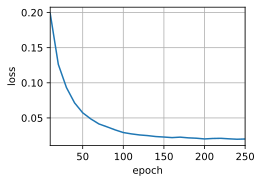

In [4]:
# 训练
embed_size, num_hiddens, num_layers, dropout = 32, 32, 2, 0.1
batch_size, num_steps = 64, 10
lr, num_epochs, device = 0.005, 250, d2l.try_gpu()

# train_iter, src_vocab, tgt_vocab = load_data_nmt(batch_size, num_steps)
train_iter, src_vocab, tgt_vocab = d2l.load_data_nmt(batch_size, num_steps, num_examples=600)

encoder = d2l.Seq2SeqEncoder(len(src_vocab), embed_size, num_hiddens, num_layers, dropout)
decoder = Seq2SeqAttentionDecoder(len(tgt_vocab), embed_size, num_hiddens, num_layers, dropout)

net = d2l.EncoderDecoder(encoder, decoder)

d2l.train_seq2seq(net, train_iter, lr, num_epochs, tgt_vocab, device)

In [24]:
# 将几个英语句子翻译成汉语
engs = ['go', "i lost .", 'he\'s calm .', 'i\'m home .'] 
fras = ['va !', 'j\'ai perdu .', 'il est calme .', 'je suis chez moi .']
for eng, fra in zip(engs, fras):
    # 注意这里的save_attention_weights要设置为True
    translation, dec_attention_weight_seq = d2l.predict_seq2seq(net, eng, src_vocab,
                                                    tgt_vocab, num_steps, device, save_attention_weights=True)
    print(f' {eng} => {translation}, ',
         f'bleu {d2l.bleu(translation, fra, k=2):.3f}')  # k=2表示计算的从1-gram开始到2-gram为止

 go => va !,  bleu 1.000
 i lost . => j'ai perdu .,  bleu 1.000
 he's calm . => il est paresseux .,  bleu 0.658
 i'm home . => je suis chez moi .,  bleu 1.000


In [25]:
# 注意这里的dec_attention_weight_seq是最后一个句子对应的注意力权重
# 而这里最后一句中：共有6个query，分别是 <bos> + “je suis chez moi .” 共计6个单词
# 所以共有6个query所对应的attention，每个attention的长度又为num_steps=10
# 这也就是下面出现 6 * 10 的原因

print(len(dec_attention_weight_seq))
print(len(dec_attention_weight_seq[0]))
print(dec_attention_weight_seq[0][0].shape)

attention_weights = torch.cat([step[0][0][0] for step in dec_attention_weight_seq], 0)
print(attention_weights.shape)

attention_weights = attention_weights.reshape((1, 1, -1, num_steps))
print(attention_weights.shape)

6
1
torch.Size([1, 1, 10])
torch.Size([60])
torch.Size([1, 1, 6, 10])


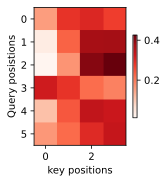

In [27]:
# 可视化注意力权重

# 本图是在翻译最后一句话“I'm home .”时的注意力的位置

# 竖着共有4列：
# len(engs[-1].split()) + 1 为“I'm home .”的长度+1，也即4
#（因为我们设置num_steps为10，也即序列长度10个单词；但是这里这句话只有3个单词 + <eos>，所以只需要看前4个即可）

# 而横着共有6行，则是因为共有6个query，分别是 <bos> + “je suis chez moi .” 共计6个单词
d2l.show_heatmaps(attention_weights[:, :, :, :len(engs[-1].split()) + 1].cpu(),
                 xlabel = 'key positions', ylabel = 'Query posistions')